# 1. Initialization

### Setup

In [1]:
import ray
import pandas as pd
import time 
import numpy as np
import binascii
import redis
import pprint
import json
import qgrid
import matplotlib.pyplot as plt
pp = pprint.PrettyPrinter() 
from misc import *

In [2]:
ray.worker._init(start_ray_local=True,num_local_schedulers=3, redirect_output = True)

Waiting for redis server at 127.0.0.1:37233 to respond...
Waiting for redis server at 127.0.0.1:25477 to respond...
Starting local scheduler with 8 CPUs and 0 GPUs.
Starting local scheduler with 8 CPUs and 0 GPUs.
Starting local scheduler with 8 CPUs and 0 GPUs.


{'local_scheduler_socket_names': ['/tmp/scheduler42139229',
  '/tmp/scheduler37425148',
  '/tmp/scheduler83920633'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store59472223', manager_name='/tmp/plasma_manager17603062', manager_port=62223),
  ObjectStoreAddress(name='/tmp/plasma_store37036917', manager_name='/tmp/plasma_manager46624397', manager_port=61222),
  ObjectStoreAddress(name='/tmp/plasma_store33510014', manager_name='/tmp/plasma_manager44407589', manager_port=45261)],
 'redis_address': '127.0.0.1:37233'}

### Function definitions

In [3]:
@ray.remote
def example(x):
    time.sleep(np.random.random())
    return np.random.randn()

@ray.remote
def example2(x): 
    return "hi"

@ray.remote
class TestCls():
    def __init__(self):
        self.g = 1
        
    def to_go(self, x):
        return x

    
@ray.remote
class Outer():
    def __init__(self):
        self.f = 1
        self.test = TestCls.remote()
    
    def to_go2(self, x):
        return x * 2
    
    def error(self):
        return 1/0

### Generate data in Redis

In [4]:
# Here, we generate data in redis for remote tasks
results = ray.get([example.remote(x) for x in range(4)])
results2 = ray.get([example2.remote(x) for x in range(20)])

# Generating data for Actor tasks
actor = TestCls.remote()
actor_results = ray.get([actor.to_go.remote(1)])

err_actor = Outer.remote()
err_actor.error.remote()

ObjectID(634b3bc51aa1fa578c07d6259b01047f0b9e7bde)

Remote function error failed with:

Traceback (most recent call last):
  File "/Users/michellemarzoev/Desktop/ray/python/ray/worker.py", line 1754, in process_task
    worker.actors[task.actor_id().id()], *arguments)
  File "<ipython-input-3-c197885e48f2>", line 29, in error
ZeroDivisionError: division by zero


You can inspect errors by running

    ray.error_info()

If this driver is hanging, start a new one with

    ray.init(redis_address="127.0.0.1:37233")



### Connect to Redis

In [5]:
addr, port = ray.worker.global_worker.redis_address.split(":")
rc = redis.StrictRedis(host=addr, port=port, decode_responses=True, encoding='latin-1', encoding_errors='replace')

# 2. Jobs Data


### Remote Functions Information

In [6]:
fn_table = ray.global_state.function_table()
fn_list = []
for fn_id in fn_table:
    val = fn_table[fn_id]
    val["function_id"] = fn_id
    fn_list.append(val)
qgrid.nbinstall(overwrite = True)
qgrid.show_grid(pd.DataFrame(fn_list))

### Task Information

In [7]:
from pandas.io.json import json_normalize

tt = ray.global_state.task_table()
tt_list = list(tt.values())
tt_list

for d in tt_list:
    d['TaskSpec']['ReturnObjectIDs'] = [oid.hex() for oid in d['TaskSpec']['ReturnObjectIDs']]

task_df = json_normalize(tt_list)
qgrid.show_grid(task_df)

### Actor Information

In [8]:
actor_info = dict()
actors = rc.keys("Actor*") 
for actor in actors:
    actor_key_str = actor[len('Actor:'):]
    actor_key_bytes = actor_key_str.encode('latin-1')
    actor_info['Actor:{}'.format(hex_identifier(actor_key_bytes))] = rc.hgetall(actor)
    x = actor_info['Actor:{}'.format(hex_identifier(actor_key_bytes))]
    if 'class_id' in x: 
        class_key_bytes = x['class_id'].encode('latin-1')
        x['class_id'] = format(hex_identifier(class_key_bytes))
    if 'driver_id' in x: 
        driver_bytes = x['driver_id'].encode('latin-1')
        x['driver_id'] = format(hex_identifier(driver_bytes))

actor_df = pd.DataFrame.from_dict(actor_info)
qgrid.show_grid(actor_df.T)

### Task - Worker Placement Information

In [9]:
event_names = rc.keys("event_log*")
results = dict()
for i in range(len(event_names)):
    event_list = rc.lrange(event_names[i], 0, -1)
    for event in event_list:
        event_dict = json.loads(event)
        task_id = ""
        worker_id = ""
        function_name = ""
    for element in event_dict:
        if "task_id" in element[3] and "worker_id" in element[3]:
            task_id = element[3]["task_id"]
            worker_id = element[3]["worker_id"]
            function_name = element[3]["function_name"]
        if task_id != "" and worker_id != "" and function_name != "":
            results[worker_id] = {}
            results[worker_id]["task_id"] = task_id
            results[worker_id]["function_name"] = function_name
results_table = pd.DataFrame.from_dict(results)
qgrid.show_grid(results_table.T)

### Task Profiles

In [10]:
task_profiles, events = ray.global_state.task_profiles()
profiles_dict = dict()
for task_id, profiles in task_profiles.items(): 
    for profile in profiles:
        start_exec = -1
        end_exec = -1 
        start_store = -1
        end_store = -1
        start_lock = -1
        end_lock = -1
        overall_start = profile[0][0]
        overall_end = profile[len(profile)-1][0]
        overall_dur = overall_end - overall_start
        for log in profile: 
            if log[1] == "ray:task:execute" and log[2] == 1: 
                start_exec = log[0]
            if log[1] == "ray:task:execute" and log[2] == 2: 
                end_exec = log[0]
            if log[1] == "ray:task:store_outputs" and log[2] == 1: 
                start_store = log[0]
            if log[1] == "ray:task:store_outputs" and log[2] == 2: 
                end_store = log[0]
            if log[1] == "ray:acquire_lock" and log[2] == 1: 
                start_lock = log[0]
            if log[1] == "ray:acquire_lock" and log[2] == 2: 
                end_lock = log[0]
        if start_exec != -1 and end_exec != -1 and start_store != -1 and end_store != -1 and start_lock != -1 and end_lock != -1:
            profiles_dict[task_id] = dict()
            exec_dur = end_exec - start_exec
            store_dur = end_store - start_store
            lock_dur = end_lock - start_lock
            overall_dur = overall_end - overall_start 
            profiles_dict[task_id]["execute"] = exec_dur
            profiles_dict[task_id]["store"] = store_dur
            profiles_dict[task_id]["acquire_lock"] = lock_dur
            profiles_dict[task_id]["total"] = overall_dur
            profiles_dict[task_id]["other"] = overall_dur - exec_dur - store_dur - lock_dur
results_table = pd.DataFrame.from_dict(profiles_dict)
qgrid.show_grid(results_table.T)



Overall Task Breakdowns:
Acquire Lock: 0.00016204371751017633%
Execute: 2.2912148110520647%
Store outputs: 0.03695809754430273%
Other: 97.67166504768612%


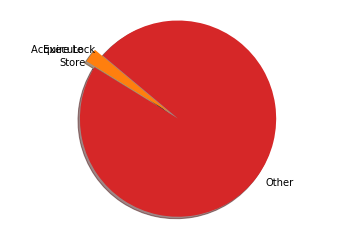

In [11]:
total_acq = 0
total_exec = 0
total_store = 0
total_other = 0
total = 0
for value in profiles_dict.values(): 
    total_exec += value["execute"]
    total_acq += value["acquire_lock"]
    total_store += value["store"]
    total_other += value["other"]
    total += value["total"]

labels = 'Acquire Lock', 'Execute', 'Store', 'Other'
sizes = [total_acq/total, total_exec/total, total_store/total, total_other/total]
explode = (0, 0.1, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=140)
plt.axis('equal')
print("Overall Task Breakdowns:")
print("Acquire Lock: " + str(total_acq/total * 100) + "%")
print("Execute: " + str(total_exec/total * 100) + "%")
print("Store outputs: " + str(total_store/total * 100) + "%")
print("Other: " + str(total_other/total * 100) + "%")
plt.show()


### Event Profiles 

In [12]:
event_list = []

# Get and decode all task timing/event logs
for key in rc.keys("event_log*"):
    content = rc.lrange(key, 0, -1)
    event_list.append(json.loads(content[0])) 
    
from collections import defaultdict

# event_dict is used to store timing info
event_dict = defaultdict(lambda: np.full(len(event_list), np.nan))

# info_dict is used to store meta data - such as function names and task id
info_dict = defaultdict(lambda: [None] * len(event_list))

for i, task_event in enumerate(event_list):
    for event in (task_event):
        time, label, startstop, info = event
        event_dict[(label, startstop)][i] = time
        if info:
            for k in info:
                info_dict[k][i] = info[k]

edf = pd.DataFrame(dict(event_dict))
edf.rename(columns={1: 'start', 2:'end'}, inplace=True)
edf

ray:acquire_lock                ray:get_task               ray:submit_task  \
              start           end         start           end           start   
0      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
1      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
2      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
3      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
4      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
5      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
6      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
7      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
8      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
9      1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09    1.497565e+09   
10     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
11     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
12     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
13     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
14     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
15     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
16     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
17     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
18     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
19     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
20     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
21     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
22     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
23     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
24     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
25     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
26     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
27     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   
28     1.497565e+09  1.497565e+09  1.497565e+09  1.497565e+09             NaN   

                      ray:task               ray:task:execute                \
             end         start           end            start           end   
0            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
1            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
2            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
3            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
4            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
5            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
6            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
7            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
8            NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
9   1.497565e+09  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
10           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
11           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
12           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
13           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
14           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
15           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.497565e+09   
16           NaN  1.497565e+09  1.497565e+09     1.497565e+09  1.4975

### Stragglers

In [13]:
event_names = rc.keys("event_log*")
x = 10
stragglers = dict()

for i in range(len(event_names)):
    event_list = rc.lrange(event_names[i], 0, -1)
    for event in event_list:
        event_dict = json.loads(event)
        task_id = ""
        overall_start = event_dict[0][0]
        overall_end = event_dict[len(event_dict)-1][0]
        overall_dur = overall_end - overall_start
        exec_start = -1
        exec_end = -1
        exec_dur = -1
        for element in event_dict:
            if element[1] == "ray:task:execute" and element[2] == 1:
                exec_start = element[0]
            if element[1] == "ray:task:execute" and element[2] == 2:
                exec_end = element[0]
            if "task_id" in element[3]:
                task_id = element[3]["task_id"]
        if exec_start != -1 and exec_end != -1 and task_id != "":
            exec_dur = exec_end - exec_start
            if len(stragglers.keys()) < x:
                stragglers[task_id] = exec_dur
            if len(stragglers.keys()) == x:
                shortest_time = min(stragglers.values()) 
                for tid, time in stragglers.items(): 
                    if time == shortest_time: 
                        del[tid] 
                        stragglers[task_id] = exec_dur 
                        break
results_table = pd.DataFrame(stragglers, index = [0])
qgrid.show_grid(results_table.T)


### Reconstructed Task Information

In [14]:
event_names = rc.keys("event_log*")
attempted = dict()
reconstructed = dict()
for i in range(len(event_names)):
    event_list = rc.lrange(event_names[i], 0, -1)
    for event in event_list:
        event_dict = json.loads(event)
        task_id = ""
        for element in event_dict:
            if "task_id" in element[3]:
                task_id = element[3]["task_id"]
        if task_id != "":
            if task_id in attempted:
                if task_id not in reconstructed:
                    reconstructed[task_id] = 0
                    reconstructed[task_id] += 1
                else:
                    attempted[task_id] = True
results_table = pd.DataFrame(reconstructed)
qgrid.show_grid(results_table)
# include objects

# 3. System State


### Node Information

In [15]:
# Using the global state API, we can populate a DataFrame with a list of Redis Clients currently connected
ctable = ray.global_state.client_table()

client_list = []
for node_ip in ctable:
    for client in ctable[node_ip]:
        client["node_ip_address"] = node_ip
        client_list.append(client)

client_df = pd.DataFrame(client_list)
qgrid.show_grid(client_df)

### Object Store

In [16]:
# We can populate a DataFrame with a list of objects in the object store
object_dict = {oid.hex(): v for oid, v in ray.global_state.object_table().items()}
object_df = pd.DataFrame(object_dict).transpose()
qgrid.show_grid(object_df)

### Object - Worker Placement Information 

In [17]:
# Objects associated with each worker_id 
object_table = ray.global_state.object_table()
location_to_objects = dict()

for object_id, object_descriptor in object_table.items():
    if object_descriptor["ManagerIDs"] != None: 
        for location in object_descriptor["ManagerIDs"]:
            if location not in location_to_objects:
                location_to_objects[location] = []
            object_id = str(object_id)
            obj_comp = object_id.split("(")
            obj_comps = obj_comp[1].split(")") 
            object_id = obj_comps[0]
            location_to_objects[location].append(object_id)
table = pd.DataFrame.from_dict(location_to_objects)
qgrid.show_grid(table)
# object id -> worker id 
# skew in how objects are distributed 
# physical nodes -> total amt data on node, num tasks 

IndexError: list index out of range

### Worker Information

In [18]:
workers = rc.keys("Worker*") 
worker_info = dict()
for worker in workers:
    worker_key_str = worker[len('Workers:'):]
    worker_key_bytes = worker_key_str.encode('latin-1')
    worker_info['Workers:{}'.format(hex_identifier(worker_key_bytes))] = rc.hgetall(worker)
table = pd.DataFrame.from_dict(worker_info)
qgrid.show_grid(table.T)
# resource info for each physical node 
# double check the IP 

### Object Transfer Information 

In [41]:
log_files = ray.global_state.log_files()
transferred = dict()
for addr, inner_dict in log_files.items(): 
    for filename, contents in inner_dict.items(): 
        if "plasma_manager" in filename and ".out" in filename:
            cont = str(contents).split("ObjectID: ") 
            cont2 = cont[1].split("\\n")
            if cont2[0] not in transferred:
                transferred[cont2[0]] = 0 
            transferred[cont2[0]] += 1 
table = pd.DataFrame(transferred, index = [0]) 
qgrid.show_grid(table.T)


# 3. Error Information

### Error Profiles


In [19]:
event_names = rc.keys("event_log*")
error_profiles = dict()
for i in range(len(event_names)):
    event_list = rc.lrange(event_names[i], 0, -1)
    for event in event_list:
        event_dict = json.loads(event)
        task_id = ""
        traceback = ""
        worker_id = ""
        start_time = -1
    for element in event_dict:
        if element[1] == "ray:task:execute" and element[2] == 1:
            start_time = element[0]
        if "task_id" in element[3] and "worker_id" in element[3]:
            task_id = element[3]["task_id"]
            worker_id = element[3]["worker_id"]
        if "traceback" in element[3]:
            traceback = element[3]["traceback"]
        if task_id != "" and worker_id != "" and traceback != "":
            if start_time != -1:
                error_profiles[task_id] = dict()
                error_profiles[task_id]["worker_id"] = worker_id
                error_profiles[task_id]["traceback"] = traceback
                error_profiles[task_id]["start_time"] = start_time
table = pd.DataFrame.from_dict(error_profiles) 
qgrid.show_grid(table.T)